# Test simulating compendia by random sampling

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import umap
from plotnine import (ggplot,
                      labs,  
                      geom_point,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)


import warnings
warnings.filterwarnings(action='ignore')

from ponyo import utils, train_vae_modules, simulate_expression_data

np.random.seed(123)

Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))
config_file = os.path.abspath(os.path.join(base_dir,
                                           "human_tests", 
                                           "config_test_human.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load parameters
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
analysis_name = params["simulation_type"]
train_architecture = params['NN_architecture']
num_simulated_samples = params['num_simulated_samples']

In [4]:
# Input files
rpkm_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "recount2_gene_RPKM_data_test.tsv")
assert os.path.exists(rpkm_data_file)

## Setup directories

In [5]:
utils.setup_dir(config_file)

## Pre-process data

In [6]:
# Output file
normalized_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "recount2_gene_normalized_data_test.tsv.xz")

In [7]:
train_vae_modules.normalize_expression_data(base_dir,
                                            config_file,
                                            rpkm_data_file,
                                            normalized_data_file)

input: dataset contains 50 samples and 5000 genes
Output: normalized dataset contains 50 samples and 5000 genes


## Train VAE

In [8]:
# Directory containing log information from VAE training
vae_log_dir = os.path.join(
    base_dir, 
    dataset_name,
    "logs",
    train_architecture)

input dataset contains 50 samples and 5000 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.
Train on 45 samples, validate on 5 samples
Epoch 1/10
45/45 [==============================] - 4s 93ms/step - loss: 2552.4357 - val_loss: 2095.1938
Epoch 2/10
45/45 [==============================] - 4s 81ms/step - loss: 1653.4071 - val_loss: 1738.1135
Epoch 3/10
45/45 [==============================] - 4s 82ms/step - loss: 1511.2294 - val_loss: 1505.0784
Epoch 4/10
45/45 [==============================] - 4s 81ms/step - loss: 1425.3800 - val_loss: 1608.0077
Epoch 5/10
45/45 [==============================] - 4s 81ms/step - loss: 1500.9716 - val_loss: 1555.3097
Epoch 6/10
45/45 [==============================] - 4s 82ms/step - loss: 1532.2508 - val_loss: 1557.1571
Epoch 7/10
45/45 [==============================] - 4s 81ms/step - loss: 1382.8551 - val_loss:

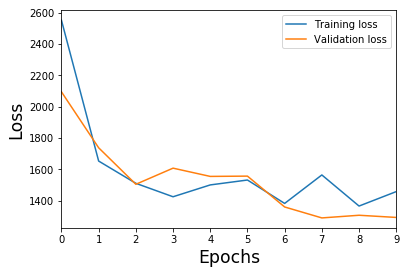

In [9]:
# Train VAE
train_vae_modules.train_vae(config_file,
                            normalized_data_file)

## Simulate data by random sampling

In [10]:
# Run simulation
simulated_data = simulate_expression_data.simulate_by_random_sampling(
    normalized_data_file,
    train_architecture,
    dataset_name,
    analysis_name,
    num_simulated_samples,
    local_dir,
    base_dir,
)

Normalized gene expression data contains 50 samples and 5000 genes
Return: simulated gene expression data containing 100 samples and 5000 genes


In [11]:
simulated_data.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.595537,0.069945,0.130497,0.067531,0.054856,0.086798,0.380836,0.612304,0.010272,0.024837,...,0.127542,0.220627,0.047489,0.127272,0.085842,0.115866,0.048533,0.267679,0.384448,0.032589
1,0.219318,0.281544,0.107503,0.103230,0.150270,0.213079,0.390845,0.349823,0.053466,0.061096,...,0.380454,0.351860,0.062284,0.168060,0.092906,0.187954,0.071249,0.280551,0.194743,0.048120
2,0.269661,0.052792,0.131061,0.089439,0.018940,0.059372,0.192204,0.190628,0.004989,0.014980,...,0.116805,0.093910,0.029965,0.104437,0.081979,0.219867,0.027432,0.127550,0.169893,0.033855
3,0.647942,0.172866,0.078719,0.058776,0.160278,0.175729,0.626273,0.724432,0.031929,0.031569,...,0.290427,0.351659,0.031259,0.130891,0.044223,0.112557,0.059977,0.376310,0.473062,0.023064
4,0.567677,0.189545,0.061688,0.038017,0.103285,0.146731,0.616618,0.738347,0.023144,0.022683,...,0.314112,0.363714,0.020498,0.120510,0.021749,0.104716,0.048917,0.347072,0.410934,0.020093


## Visualize random sampled compendium

In [12]:
# Read data
normalized_data = pd.read_csv(normalized_data_file, header=0, sep="\t", index_col=0)

In [13]:
normalized_data.head()

,ENSG00000086200.16,ENSG00000279019.1,ENSG00000206772.1,ENSG00000252996.1,ENSG00000277635.1,ENSG00000224790.2,ENSG00000106636.7,ENSG00000152443.12,ENSG00000225819.1,ENSG00000237377.2,...,ENSG00000281392.1,ENSG00000241627.3,ENSG00000239216.1,ENSG00000256797.1,ENSG00000221263.1,ENSG00000249478.1,ENSG00000283340.1,ENSG00000242052.1,ENSG00000264443.1,ENSG00000236858.1
SRR592745,0.080978,0.886399,0.0,0.000654,0.676113,0.092019,0.563159,0.626964,0.0,0.000000,...,0.237537,0.241719,0.0,0.000000,0.0,0.000000,0.0,0.308343,0.111808,0.025641
SRR592746,0.087339,0.161515,0.0,0.000000,1.000000,0.053521,0.386222,0.333747,0.0,0.000000,...,0.114370,0.334752,0.0,0.000000,0.0,0.000000,0.0,0.124547,0.166928,0.000000
SRR592747,0.131139,0.411128,0.0,0.000000,0.000000,0.138028,0.514365,0.629170,0.0,0.000000,...,0.064516,0.514277,0.0,0.326923,0.0,0.000000,0.0,0.267231,0.149227,0.000000
SRR592748,0.144581,0.241113,0.0,0.044672,0.000000,0.135211,0.597027,0.866832,0.0,0.237624,...,1.000000,0.547814,0.0,0.000000,0.0,0.009901,0.0,0.637243,0.255882,0.041026
SRR592749,0.202282,0.047913,0.0,0.000000,0.000000,0.090141,0.667133,0.773918,0.0,0.000000,...,0.850440,0.486658,0.0,0.000000,0.0,0.014851,0.0,0.712213,0.230114,0.000000


In [14]:
model = umap.UMAP(random_state=123).fit(normalized_data)

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])

In [15]:
# UMAP embedding of simulated data

simulated_data_UMAPencoded = model.transform(simulated_data)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

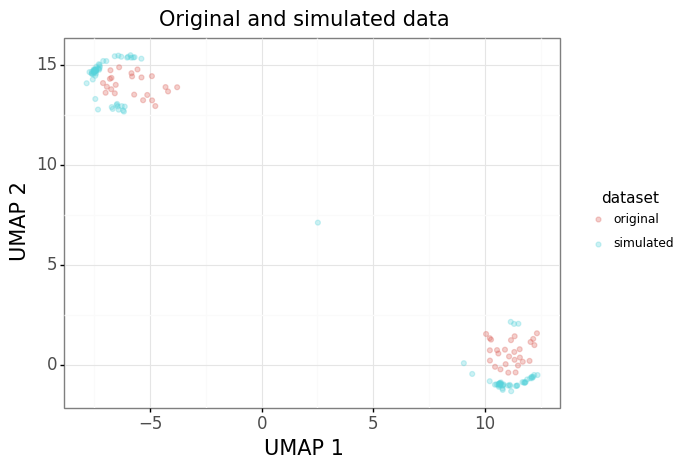

<ggplot: (-9223363306863442958)>


In [16]:
# Overlay original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
g_input_sim = ggplot(combined_data_df, aes(x='1', y='2'))
g_input_sim += geom_point(aes(color='dataset'),alpha=0.3)
g_input_sim += labs(x = "UMAP 1",
                    y = "UMAP 2", 
                    title = "Original and simulated data")
g_input_sim += theme_bw()
g_input_sim += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)

)

print(g_input_sim)